In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:80% !important;}</style>"))

In [3]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
inp0 = pd.read_csv('AAPL.csv')
inp0.head()

,Date,Close,Open,High,Low,Volume
0,1/17/2020,138.31,136.54,138.330,136.16,5623336
1,1/16/2020,137.98,137.32,138.190,137.01,4320911
2,1/15/2020,136.62,136.00,138.055,135.71,4045952
3,1/14/2020,135.82,136.28,137.139,135.55,3683458
4,1/13/2020,136.60,135.48,136.640,135.07,3531572


In [4]:
inp0.tail()

,Date,Open,High,Low,Close,Volume
1659,7-Jan-11,47.71,48.05,47.41,48.02,77982212
1660,6-Jan-11,47.82,47.89,47.56,47.68,75106626
1661,5-Jan-11,47.08,47.76,47.07,47.71,63879193
1662,4-Jan-11,47.49,47.50,46.88,47.33,77337001
1663,3-Jan-11,46.52,47.18,46.41,47.08,111280407


### Exercise 5.01: Visualizing our time series data  

1. Plot the column 'Close' as a line plot to see the pattern using the plot method of the dataframe

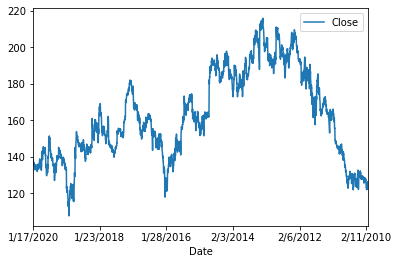

In [6]:
inp0.plot("Date", "Close")
plt.show()

2. We see that the index is in reverse order - latest date beginning at 0. We’ll reverse the data for convenience of plotting and handling.

In [9]:
inp0 = inp0.sort_index(ascending=False)

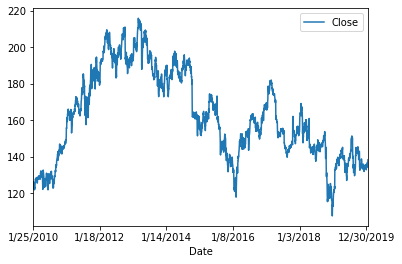

In [11]:
inp0.plot("Date", "Close")
plt.show()

3.	Extract the values for ‘Close’ from the dataframe as a numpy array.

In [12]:
ts_data = inp0.Close.values

In [10]:
ts_data[:4]

array([[47.08],
       [47.33],
       [47.71],
       [47.68]])

5. Plot the values as a line plot using matplotlib

In [13]:
%matplotlib inline

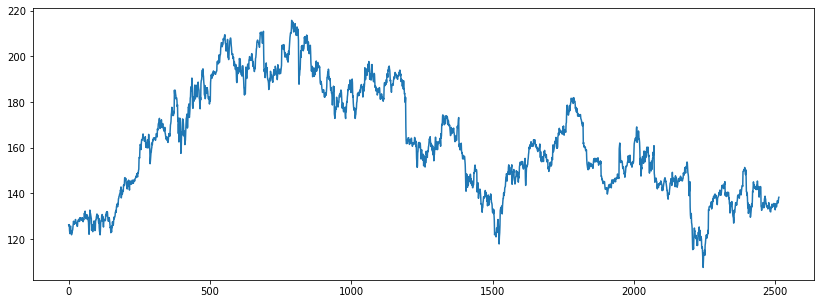

In [16]:
plt.figure(figsize=[14,5])
plt.plot(ts_data)
plt.show()

### Exercise 5.02: Simple RNN using Tensorflow

1. Import Tensorflow and numpy

In [13]:
import numpy as np
import tensorflow as tf
np.random.seed(0)

2. Define constants ‘num_inputs’ and ‘num_neurons’ holding the number of inputs (2) and the number of neurons in the hidden layer (3) respectively.

In [65]:
num_inputs = 2
num_neurons = 3

3. Define the variables for the weight matrices. We need two of them – one for the feedforward weights, the other for the recurrent weights. Initialize them randomly.

In [83]:
Wf = tf.Variable(tf.random.normal(shape=[num_inputs, num_neurons]))
Wr = tf.Variable(tf.random.normal(shape=[num_neurons, num_neurons]))

4. Add the bias variable, as many values as the number of neurons in the hidden layer

In [94]:
b = tf.Variable(tf.zeros([1,num_neurons]))

5. Create the data – 3 examples for xt0 (two inputs, 3 examples) as [[0,1],[2,3],[4,5]] and xt1 as [[100,101],[102,103],[104,105]]

In [104]:
xt0_batch = np.array([[0,1],  [2,3], [4,5]]).astype(np.float32)
xt1_batch = np.array([[100, 101], [102, 103], [104, 105]]).astype(np.float32)

6. Define function to apply forward pass for given data xt0, xt1

In [100]:
@tf.function
def forward_pass(xt0, xt1):
    yt0 = tf.tanh(tf.matmul(xt0, Wf) + b)
    yt1 = tf.tanh(tf.matmul(yt0, Wr) + tf.matmul(xt1, Wf) + b)
    return yt0, yt1

7. Perform the forward pass by calling the function with the created data

In [105]:
yt0_output, yt1_output = forward_pass(xt0_batch, xt1_batch)

11. Print the output values yt0 and yt1

In [109]:
tf.print(yt0_output)

[[0.552615523 -0.58737725 0.263880163]
 [0.13388668 -0.997615159 0.791431]
 [-0.338810503 -0.999989092 0.954512119]]


In [110]:
tf.print(yt1_output)

[[-1 -1 1]
 [-1 -1 1]
 [-1 -1 1]]


### Train test split on our time series data

In [17]:
train_recs = int(len(ts_data) * 0.75)

In [18]:
train_data = ts_data[:train_recs]
test_data = ts_data[train_recs:]

In [19]:
len(train_data), len(test_data)

(1248, 416)

#### Scaling the data

In [20]:
from sklearn.preprocessing import MinMaxScaler

In [21]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

In [22]:
def get_lookback(inp, look_back=5):       
    y = pd.DataFrame(inp)
    dataX = [y.shift(i) for i in range(1, look_back+1)]
    dataX = pd.concat(dataX, axis=1)
    dataX.fillna(0, inplace = True)
    return dataX.values, y.values

In [23]:
look_back = 10

In [24]:
trainX, trainY = get_lookback(train_scaled, look_back=look_back)
testX, testY = get_lookback(test_scaled, look_back= look_back)

In [25]:
trainX.shape, testX.shape

((1248, 10), (416, 10))

In [35]:
# # reshape input to be [samples, time steps, features]
# trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
# testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Activation, Dropout, Dense, Reshape
from sklearn.metrics import mean_squared_error

In [27]:
?SimpleRNN

In [49]:
?Reshape

In [28]:
num_neurons = 32

In [29]:
model = Sequential()
model.add(Reshape((look_back,1), input_shape = (look_back,)))
model.add(SimpleRNN(32, input_shape=(look_back, 1)))
model.add(Dense(1))
model.add(Activation('linear'))

In [30]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 10, 1)             0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                1088      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2, validation_split=0.1)

Train on 1123 samples, validate on 125 samples
Epoch 1/5
1123/1123 - 11s - loss: 0.0031 - val_loss: 0.0031
Epoch 2/5
1123/1123 - 8s - loss: 0.0011 - val_loss: 9.2456e-04
Epoch 3/5
1123/1123 - 8s - loss: 7.7409e-04 - val_loss: 8.5173e-04
Epoch 4/5
1123/1123 - 5s - loss: 5.6903e-04 - val_loss: 0.0026
Epoch 5/5
1123/1123 - 4s - loss: 7.4071e-04 - val_loss: 0.0095


In [33]:
import math

In [34]:
def get_model_perf(model_obj):

    score_train = model_obj.evaluate(trainX, trainY, verbose=0)
    print('Train RMSE: %.2f RMSE' % (math.sqrt(score_train)))

    score_test = model_obj.evaluate(testX, testY, verbose=0)
    print('Test RMSE: %.2f RMSE' % (math.sqrt(score_test)))

In [35]:
get_model_perf(model)

Train RMSE: 0.05 RMSE
Test RMSE: 0.08 RMSE


#### Function to plot the predictions from the model

In [36]:
def plot_pred(model_obj):
    testPredict = scaler.inverse_transform(model_obj.predict(testX))
    
    pred_test_plot = ts_data.copy()
    pred_test_plot[:train_recs+look_back,:] = np.nan
    pred_test_plot[train_recs+look_back:,:] = testPredict[look_back:]
    
    plt.plot(ts_data)
    plt.plot(pred_test_plot)

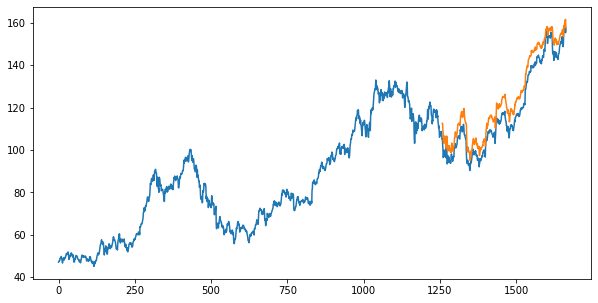

In [37]:
plt.figure(figsize=[10,5])
plot_pred(model)

<IPython.core.display.Javascript object>


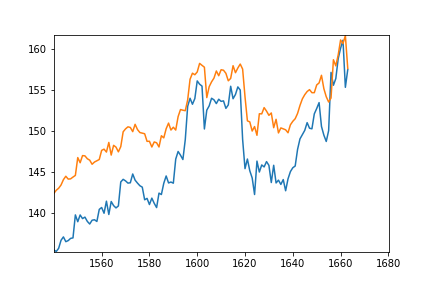

In [40]:
%matplotlib notebook
plot_pred(model)

In [41]:
%matplotlib inline

### 1D convnet model for time series prediction

In [42]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, GlobalMaxPooling1D

In [43]:
?Conv1D

In [44]:
look_back

10

In [ ]:
# model_conv = Sequential()
# model_conv.add(Reshape((look_back,1), input_shape = (look_back,)))
# #model_conv.add(Conv1D(10, 3, strides=4, activation='relu', input_shape=(look_back,1)))
# model_conv.add(Conv1D(10, 3, activation='relu', input_shape=(look_back,1)))
# model_conv.add(MaxPooling1D(pool_size=1))
# #model_conv.add(Conv1D(10, 3, activation='relu', input_shape=(look_back,1)))
# model_conv.add(Flatten())
# model_conv.add(Dense(1))
# model_conv.add(Activation('linear'))

In [384]:
?Conv1D

In [401]:
?MaxPooling1D

In [45]:
model_conv = Sequential()
model_conv.add(Reshape((look_back,1), input_shape = (look_back,)))
model_conv.add(Conv1D(5, 5, activation='relu'))
#model_conv2.add(GlobalMaxPooling1D())
model_conv.add(MaxPooling1D(5))
model_conv.add(Flatten())
model_conv.add(Dense(1))
model_conv.add(Activation('linear'))

In [46]:
model_conv.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 10, 1)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 6, 5)              30        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 5)              0         
_________________________________________________________________
flatten (Flatten)            (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 36
Trainable params: 36
Non-trainable params: 0
__________________________________________________________

In [47]:
model_conv.compile(loss='mean_squared_error', optimizer='adam')

In [48]:
model_conv.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2, validation_split=0.1)

Train on 1123 samples, validate on 125 samples
Epoch 1/5
1123/1123 - 2s - loss: 0.0024 - val_loss: 0.0019
Epoch 2/5
1123/1123 - 2s - loss: 8.7797e-04 - val_loss: 0.0017
Epoch 3/5
1123/1123 - 2s - loss: 8.8367e-04 - val_loss: 0.0019
Epoch 4/5
1123/1123 - 2s - loss: 8.3218e-04 - val_loss: 0.0027
Epoch 5/5
1123/1123 - 2s - loss: 8.5450e-04 - val_loss: 0.0016


In [49]:
get_model_perf(model_conv)

Train RMSE: 0.03 RMSE
Test RMSE: 0.07 RMSE


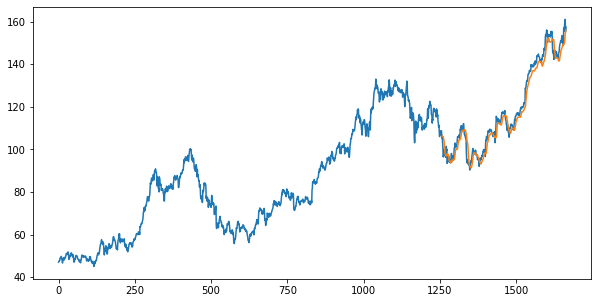

In [50]:
%matplotlib inline
plt.figure(figsize=[10,5])
plot_pred(model_conv)

<IPython.core.display.Javascript object>


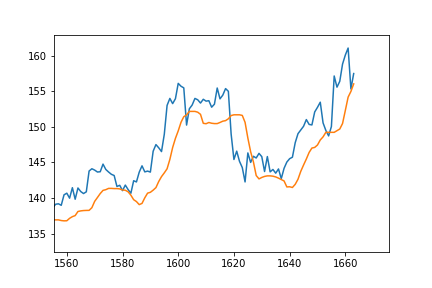

In [52]:
%matplotlib notebook
plot_pred(model_conv)

In [53]:
%matplotlib inline

### Using 1D convnets along with RNNs

In [54]:
model_comb = Sequential()
model_comb.add(Reshape((look_back,1), input_shape = (look_back,)))
model_comb.add(Conv1D(5, 3, activation='relu'))
#model3.add(MaxPooling1D(pool_size=6))
model_comb.add(SimpleRNN(32))
model_comb.add(Dense(1))
model_comb.add(Activation('linear'))

In [55]:
model_comb.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 10, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 5)              20        
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                1216      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 1,269
Trainable params: 1,269
Non-trainable params: 0
_________________________________________________________________


In [56]:
model_comb.compile(loss='mean_squared_error', optimizer='adam')

In [57]:
model_comb.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2, validation_split=0.1)

Train on 1123 samples, validate on 125 samples
Epoch 1/5
1123/1123 - 5s - loss: 0.0068 - val_loss: 0.0024
Epoch 2/5
1123/1123 - 4s - loss: 0.0014 - val_loss: 0.0043
Epoch 3/5
1123/1123 - 4s - loss: 0.0015 - val_loss: 0.0019
Epoch 4/5
1123/1123 - 4s - loss: 0.0013 - val_loss: 0.0019
Epoch 5/5
1123/1123 - 4s - loss: 0.0013 - val_loss: 0.0021


In [58]:
get_model_perf(model_comb)

Train RMSE: 0.03 RMSE
Test RMSE: 0.07 RMSE


<IPython.core.display.Javascript object>


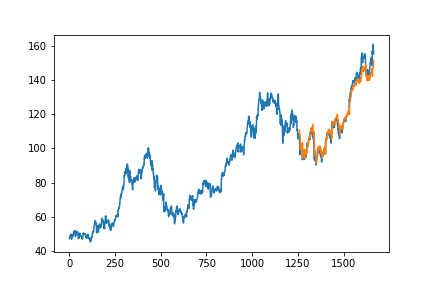

In [59]:
%matplotlib notebook
plot_pred(model_comb)

<IPython.core.display.Javascript object>


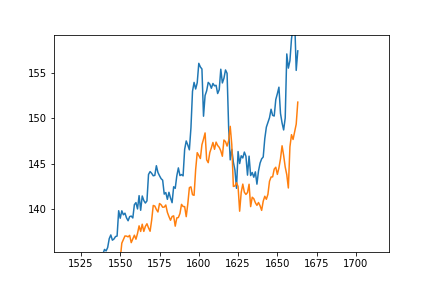

In [60]:
%matplotlib notebook
plot_pred(model_comb)

In [87]:
%matplotlib inline

## Activity 5.1: IBM stock price prediction using RNNs + 1D convnet

1. Load the csv file, reverse the index and plot the time series (‘Close’ column) for visual inspection

In [61]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

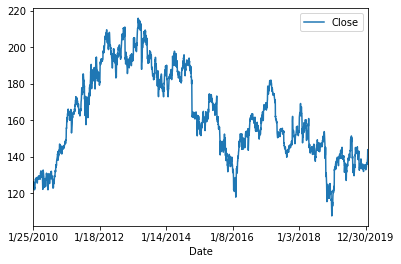

In [18]:
inp0 = pd.read_csv("IBM.csv")
inp0 = inp0.sort_index(ascending=False)
inp0.plot("Date", "Close")
plt.show()

In [146]:
inp0.shape

(2518, 6)

In [147]:
inp1 = inp0[["Close"]]
inp1 = inp1.sort_index(ascending=False)
ts_data = inp1.values

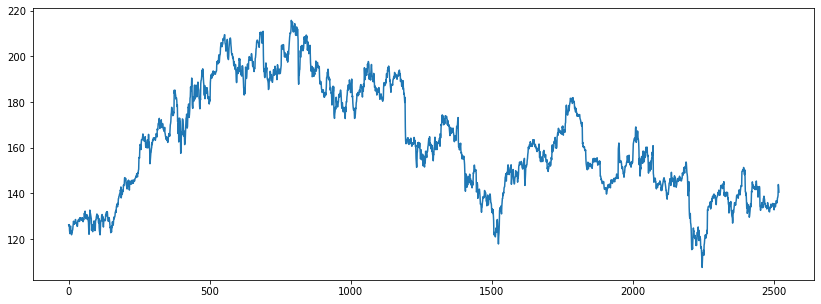

In [148]:
%matplotlib inline
plt.figure(figsize=[14,5])
plt.plot(ts_data)
plt.show()

2. Assign the final 25% data as test data, first 75% as train

In [149]:
train_recs = int(len(ts_data) * 0.75)

In [150]:
train_data = ts_data[:train_recs]
test_data = ts_data[train_recs:]

In [151]:
len(train_data), len(test_data)

(1888, 630)

3. Using MinMaxScaler from sklearn, scale the train and test data

In [152]:
from sklearn.preprocessing import MinMaxScaler

In [153]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

4. Using the get_lookback function defined in the chapter, get lookback data for train and the test data using a lookback period of 10.

In [154]:
look_back = 10

In [155]:
trainX, trainY = get_lookback(train_scaled, look_back=look_back)
testX, testY = get_lookback(test_scaled, look_back= look_back)

In [156]:
trainX.shape, testX.shape

((1888, 10), (630, 10))

5. From Keras, import all necessary layers for employing plain RNNs (SimpleRNN, Activation, Dropout, Dense, Reshape) and 1D convolutions (Conv1D). Also import mean_squared_error metric from sklearn

In [157]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Activation, Dropout, Dense, Reshape, Conv1D
from sklearn.metrics import mean_squared_error

6. Build a model with a 1D convolution layer (5 filters of size 3) and an RNN layer with 32 neurons. Add 25% dropout after the RNN layer. Print the model’s summary.

In [215]:
model_comb = Sequential()
model_comb.add(Reshape((look_back,1), input_shape = (look_back,)))
model_comb.add(Conv1D(5, 3, activation='relu'))
model_comb.add(SimpleRNN(32))
model_comb.add(Dropout(0.25))
model_comb.add(Dense(1))
model_comb.add(Activation('linear'))

In [216]:
model_comb.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_21 (Reshape)         (None, 10, 1)             0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 8, 5)              20        
_________________________________________________________________
simple_rnn_20 (SimpleRNN)    (None, 32)                1216      
_________________________________________________________________
dropout_15 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
_________________________________________________________________
activation_20 (Activation)   (None, 1)                 0         
Total params: 1,269
Trainable params: 1,269
Non-trainable params: 0
_________________________________________________________________


7. Compile the model with “mean_squared_error” loss and ‘adam’ optimizer. Fit on the train data in 5 epochs, validation split of 10%, batch size of 1.

In [217]:
model_comb.compile(loss='mean_squared_error', optimizer='adam')

In [218]:
model_comb.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2, validation_split=0.1)

Train on 1699 samples, validate on 189 samples
Epoch 1/5
 - 9s - loss: 0.0091 - val_loss: 5.8139e-04
Epoch 2/5
 - 7s - loss: 0.0045 - val_loss: 0.0013
Epoch 3/5
 - 7s - loss: 0.0035 - val_loss: 4.6101e-04
Epoch 4/5
 - 7s - loss: 0.0026 - val_loss: 6.0750e-04
Epoch 5/5
 - 7s - loss: 0.0022 - val_loss: 6.1270e-04


8. Using the get_model_perf method, print the RMSE from the model.

In [219]:
get_model_perf(model_comb)

Train RMSE: 0.03 RMSE
Test RMSE: 0.03 RMSE


9. Plot the predictions - the entire view, as well as zoomed in view

<IPython.core.display.Javascript object>


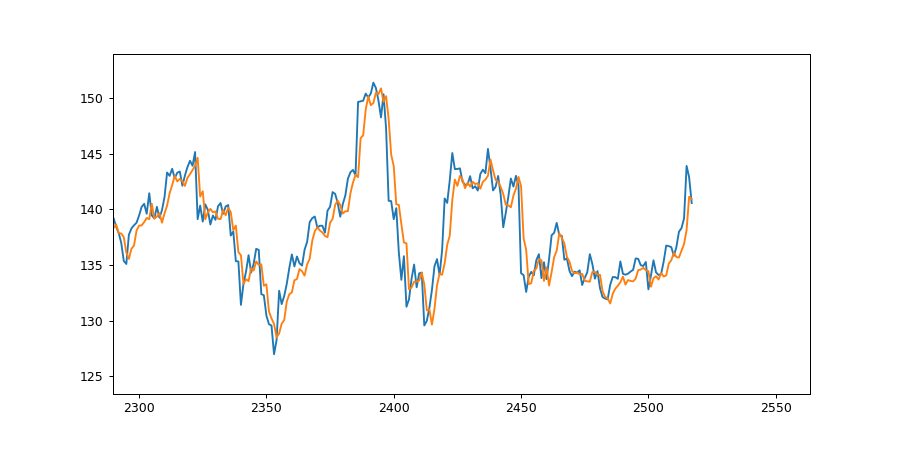

In [220]:
%matplotlib notebook
plt.figure(figsize=[10,5])
plot_pred(model_comb)